**Mount the google drive on the colab session**

In [ ]:
#Mounting gdrive to gain access to the dataset
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Importing necessary libraries**

In [ ]:
#Importing necessary libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
import nltk
nltk.download('wordnet')
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Importing and cleaning data off the unwanted data inputs**

In [ ]:
#importing data from google drive
data = pd.read_json('/content/gdrive/My Drive/cran_d.json')
data.drop(['author', 'bibliography','title'], axis = 1)

,id,body
0,1,experimental investigation of the aerodynamics...
1,2,simple shear flow past a flat plate in an inco...
2,3,the boundary layer in simple shear flow past a...
3,4,approximate solutions of the incompressible la...
4,5,one-dimensional transient heat conduction into...
...,...,...
1395,1396,shear buckling of clamped and simply-supported...
1396,1397,critical shear stress of an infinitely long si...
1397,1398,stability of rectangular plates under shear an...
1398,1399,buckling of transverse stiffened plates under ...


**Preprocessing the data**

In [ ]:
#Data Preprocessing (stemming, Lemmeatizing and Tokenizing)
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [ ]:
processed_data = data['body'].map(preprocess)
processed_data

0       [experiment, investig, aerodynam, wing, slipst...
1       [simpl, shear, flow, past, flat, plate, incomp...
2       [boundari, layer, simpl, shear, flow, past, fl...
3       [approxim, solut, incompress, laminar, boundar...
4       [dimension, transient, heat, conduct, doubl, l...
                              ...                        
1395    [shear, buckl, clamp, simpli, support, infinit...
1396    [critic, shear, stress, infinit, long, simpli,...
1397    [stabil, rectangular, plat, shear, bend, forc,...
1398    [buckl, transvers, stiffen, plat, shear, paper...
1399    [buckl, shear, stress, simpli, support, infini...
Name: body, Length: 1400, dtype: object

**Dictionary and Corpus Creation **

In [ ]:
#Creating dictionary and the word corpus
dictionary = corpora.Dictionary(processed_data)
corpus = [dictionary.doc2bow(text) for text in processed_data]

**Setting up the environment for LDAMallet execution**

In [ ]:
#environment setup for executing the Mallet LDA
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

**Finding the optimal number of topics**

In [ ]:
def coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=2, limit=22, step=2)

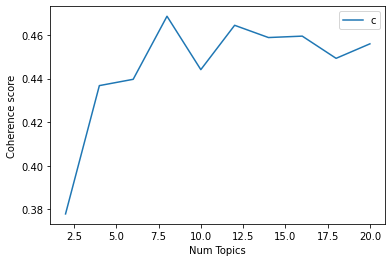

In [ ]:
limit=22; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for i, cv in zip(x, coherence_values):
    print("Num Topics =", i, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.378
Num Topics = 4  has Coherence Value of 0.4368
Num Topics = 6  has Coherence Value of 0.4396
Num Topics = 8  has Coherence Value of 0.4686
Num Topics = 10  has Coherence Value of 0.4441
Num Topics = 12  has Coherence Value of 0.4644
Num Topics = 14  has Coherence Value of 0.4588
Num Topics = 16  has Coherence Value of 0.4594
Num Topics = 18  has Coherence Value of 0.4493
Num Topics = 20  has Coherence Value of 0.4559


**Building the LDAMallet model with the optimal number of topic**

In [ ]:
import pprint
ldamallet1 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=dictionary)
pprint.pprint(ldamallet1.show_topics(formatted=False))

[(2,
  [('wing', 0.08864647320482949),
   ('edg', 0.03717432747299301),
   ('superson', 0.03675068841347172),
   ('lead', 0.033043846642660454),
   ('flow', 0.03251429781825884),
   ('lift', 0.028807456047447576),
   ('speed', 0.027218809574242744),
   ('ratio', 0.021393772505825037),
   ('airfoil', 0.01885193814869731),
   ('subson', 0.017475111205253125)]),
 (9,
  [('theori', 0.09961642599277978),
   ('result', 0.057310469314079425),
   ('experiment', 0.053023465703971116),
   ('data', 0.03203971119133574),
   ('show', 0.03125),
   ('predict', 0.031137184115523464),
   ('theoret', 0.02910649819494585),
   ('compar', 0.026398916967509026),
   ('agreement', 0.02493231046931408),
   ('experi', 0.02414259927797834)]),
 (1,
  [('number', 0.11668514412416851),
   ('pressur', 0.11271249076127125),
   ('mach', 0.07594235033259424),
   ('measur', 0.035846267553584624),
   ('investig', 0.030210643015521066),
   ('tunnel', 0.028824833702882482),
   ('test', 0.027808573540280858),
   ('nozzl', 0

**Listing out the topics identified by the optimal model(model with high coherence value)**

In [ ]:
import pprint
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=7))

[(0,
  '0.123*"flow" + 0.060*"bodi" + 0.053*"shock" + 0.034*"wave" + 0.028*"theori" '
  '+ 0.025*"hyperson" + 0.020*"blunt"'),
 (1,
  '0.023*"high" + 0.018*"speed" + 0.016*"discuss" + 0.014*"design" + '
  '0.014*"possibl" + 0.012*"flight" + 0.011*"equilibrium"'),
 (2,
  '0.088*"number" + 0.079*"pressur" + 0.054*"mach" + 0.032*"effect" + '
  '0.031*"test" + 0.028*"measur" + 0.025*"reynold"'),
 (3,
  '0.058*"method" + 0.055*"solut" + 0.051*"equat" + 0.031*"problem" + '
  '0.024*"approxim" + 0.023*"give" + 0.022*"function"'),
 (4,
  '0.036*"angl" + 0.029*"valu" + 0.024*"drag" + 0.022*"ratio" + '
  '0.020*"determin" + 0.018*"result" + 0.018*"attack"'),
 (5,
  '0.078*"boundari" + 0.074*"layer" + 0.054*"heat" + 0.040*"temperatur" + '
  '0.031*"transfer" + 0.027*"laminar" + 0.025*"surfac"'),
 (6,
  '0.034*"cylind" + 0.031*"load" + 0.026*"stress" + 0.026*"buckl" + '
  '0.023*"result" + 0.022*"theori" + 0.022*"shell"'),
 (7,
  '0.060*"wing" + 0.026*"edg" + 0.024*"effect" + 0.021*"calcul" + 0.02

**Testing the performance of the optimal model on the unknown data**

In [ ]:
unseendata = 'Aerodynamic interaction between propellers of a distributed-propulsion system in forward flight'
corpus = dictionary.doc2bow(preprocess(unseendata))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.11208576998050683	 Topic: 0.050*"effect" + 0.028*"speed"
Score: 0.10233918128654972	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.09454191033138402	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.09064327485380119	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.08869395711500976	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.07309941520467837	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.07309941520467837	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.07309941520467837	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.07309941520467837	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.07309941520467837	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.07309941520467837	 Topic: 0.100*"theori" + 0.057*"result"
Score: 0.07309941520467837	 Topic: 0.042*"load" + 0.039*"cylind"


In [ ]:
unseendata1 = 'No One Can Explain Why Planes Stay in the Air'
corpus = dictionary.doc2bow(preprocess(unseendata1))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.09935897435897435	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.09935897435897435	 Topic: 0.100*"theori" + 0.057*"result"
Score: 0.08012820512820512	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.08012820512820512	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.08012820512820512	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.08012820512820512	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.08012820512820512	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.08012820512820512	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.08012820512820512	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.08012820512820512	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.08012820512820512	 Topic: 0.042*"load" + 0.039*"cylind"
Score: 0.08012820512820512	 Topic: 0.050*"effect" + 0.028*"speed"


In [ ]:
testdata_unseen = "Turbulence Model Could Help Design Aircraft Capable of Handling Extreme Scenarios"
corpus = dictionary.doc2bow(preprocess(testdata_unseen))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.12378167641325535	 Topic: 0.050*"effect" + 0.028*"speed"
Score: 0.10233918128654969	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.09064327485380116	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.09064327485380116	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.07894736842105263	 Topic: 0.042*"load" + 0.039*"cylind"
Score: 0.07504873294346978	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.07309941520467836	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.07309941520467836	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.07309941520467836	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.07309941520467836	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.07309941520467836	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.07309941520467836	 Topic: 0.100*"theori" + 0.057*"result"


In [ ]:
testdata_unseen1 = "Zero emissions hydrogen plane test was part powered by fossil fuels"
corpus = dictionary.doc2bow(preprocess(testdata_unseen1))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.1279761904761905	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.09623015873015874	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.08829365079365081	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.08234126984126987	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.08234126984126987	 Topic: 0.050*"effect" + 0.028*"speed"
Score: 0.07638888888888891	 Topic: 0.042*"load" + 0.039*"cylind"
Score: 0.07440476190476193	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.07440476190476193	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.07440476190476193	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.07440476190476193	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.07440476190476193	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.07440476190476193	 Topic: 0.100*"theori" + 0.057*"result"


In [ ]:
testdata_unseen2 = "Dynamic stability of wings for drone aircraft subjected to parametric excitation"
corpus = dictionary.doc2bow(preprocess(testdata_unseen2))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.1259920634920635	 Topic: 0.050*"effect" + 0.028*"speed"
Score: 0.09424603174603174	 Topic: 0.042*"load" + 0.039*"cylind"
Score: 0.09226190476190478	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.09226190476190478	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.07440476190476193	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.07440476190476193	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.07440476190476193	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.07440476190476193	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.07440476190476193	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.07440476190476193	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.07440476190476193	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.07440476190476193	 Topic: 0.100*"theori" + 0.057*"result"


In [ ]:
testdata_unseen3 = "the kink in the surge line of a multi-stage axial compressor"
corpus = dictionary.doc2bow(preprocess(testdata_unseen3))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.1315789473684211	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.10623781676413256	 Topic: 0.042*"load" + 0.039*"cylind"
Score: 0.09064327485380118	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.08284600389863549	 Topic: 0.100*"theori" + 0.057*"result"
Score: 0.0750487329434698	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.0750487329434698	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.07309941520467837	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.07309941520467837	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.07309941520467837	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.07309941520467837	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.07309941520467837	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.07309941520467837	 Topic: 0.050*"effect" + 0.028*"speed"


In [ ]:
testdata_unseen4 = "have any aerodynamic derivatives been measured at hypersonic mach numbers and comparison been made with theoretical work"
corpus = dictionary.doc2bow(preprocess(testdata_unseen4))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.11958568738229754	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.11770244821092278	 Topic: 0.100*"theori" + 0.057*"result"
Score: 0.09133709981167608	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.08380414312617702	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.08192090395480227	 Topic: 0.050*"effect" + 0.028*"speed"
Score: 0.0800376647834275	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.07250470809792844	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.07062146892655367	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.07062146892655367	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.07062146892655367	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.07062146892655367	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.07062146892655367	 Topic: 0.042*"load" + 0.039*"cylind"


In [ ]:
testdata_unseen5 = "information on the buckling of sandwich sphere available"
corpus = dictionary.doc2bow(preprocess(testdata_unseen5))
for index, score in sorted(ldamallet1[corpus], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamallet1.print_topic(index, 2)))

Score: 0.11212121212121211	 Topic: 0.042*"load" + 0.039*"cylind"
Score: 0.09393939393939393	 Topic: 0.181*"flow" + 0.077*"shock"
Score: 0.09393939393939393	 Topic: 0.100*"theori" + 0.057*"result"
Score: 0.08585858585858586	 Topic: 0.066*"present" + 0.061*"result"
Score: 0.08383838383838384	 Topic: 0.089*"wing" + 0.037*"edg"
Score: 0.07575757575757576	 Topic: 0.085*"solut" + 0.078*"equat"
Score: 0.07575757575757576	 Topic: 0.117*"number" + 0.113*"pressur"
Score: 0.07575757575757576	 Topic: 0.057*"temperatur" + 0.054*"heat"
Score: 0.07575757575757576	 Topic: 0.108*"boundari" + 0.103*"layer"
Score: 0.07575757575757576	 Topic: 0.097*"method" + 0.054*"distribut"
Score: 0.07575757575757576	 Topic: 0.090*"bodi" + 0.050*"angl"
Score: 0.07575757575757576	 Topic: 0.050*"effect" + 0.028*"speed"
